In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy
import math

In [3]:
def generate_synthetic_data(N, distribution):
    data = []
    labels = []
    if distribution == "normal":
        for _ in range(N):
            mean = np.random.uniform(0,1,1)
            batch_data = np.random.normal(mean, np.sqrt(1.0), size=(1, 10))
            data.append(batch_data)
            labels.append(mean)
    elif distribution == "exponential":
        for _ in range(N):
            mean = np.random.uniform(0,1,1)
            batch_data = np.random.exponential(mean, size=(1, 10))
            data.append(batch_data)
            labels.append(mean)
    elif distribution == "chi_squared":
        for _ in range(N):
            mean = np.random.uniform(0,1,1)
            batch_data = np.random.chisquare(df=mean, size=(1, 10))
            data.append(batch_data)
            labels.append(mean)
    elif distribution == "uniform":
        for _ in range(N):
            mean = np.random.uniform(20,50,1)
            batch_data = np.random.uniform(mean - 10, mean + 10, size=(1, 10))
            data.append(batch_data)
            labels.append(mean)
    data = np.concatenate(data, axis=0)
    labels = np.array(labels).reshape(-1, 1)
    return data, labels

# Sizes for training and testing datasets
N1, N2, N3, N4 = 1000, 1000, 800, 200
N1_test, N2_test, N3_test, N4_test = 1000, 1000, 1000, 1000

# Generate training datasets
datasets = []
distributions = ["normal", "exponential", "chi_squared", "uniform"]
sizes = [N1, N2, N3, N4]

train_data = []; train_labels = [];
for dist, size in zip(distributions, sizes):
    data, labels = generate_synthetic_data(size, dist)
    train_data.append(data)
    train_labels.append(labels)
    datasets.append((data, labels))

batch_size = 500
k = len(sizes) # Number of datasets to mix
    
# Combine train datasets
train_data = np.concatenate(train_data, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

# Convert train datasets to PyTorch tensors and create DataLoader
train_tensor_data = torch.tensor(train_data, dtype=torch.float32)
train_tensor_labels = torch.tensor(train_labels, dtype=torch.float32)
train_dataset = TensorDataset(train_tensor_data, train_tensor_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Convert training datasets to PyTorch tensors
tensor_datasets = [];
for data, labels in datasets:
    tensor_data = torch.tensor(data, dtype=torch.float32)
    tensor_labels = torch.tensor(labels, dtype=torch.float32)
    tensor_datasets.append(TensorDataset(tensor_data, tensor_labels))

# Generate test datasets
test_data = []; test_labels = [];
for dist, size in zip(distributions, [N1_test, N2_test, N3_test, N4_test]):
    if size > 0:
        data, labels = generate_synthetic_data(size, dist)
        test_data.append(data)
        test_labels.append(labels)

# Combine test datasets
test_data = np.concatenate(test_data, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Convert test datasets to PyTorch tensors and create DataLoader
test_tensor_data = torch.tensor(test_data, dtype=torch.float32)
test_tensor_labels = torch.tensor(test_labels, dtype=torch.float32)
test_dataset = TensorDataset(test_tensor_data, test_tensor_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Shuffle indices at the start of each epoch
def shuffle_class_data(tensor_datasets):
    shuffled_indices = []
    for dataset in tensor_datasets:
        num_samples = dataset.tensors[0].size(0)
        # Shuffle indices for the current class
        shuffled_indices.append(torch.randperm(num_samples))
    return shuffled_indices

In [4]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.fc(x)

In [4]:
criterion = nn.MSELoss()
N_total = sum(sizes)

# Initialize training and test losses
epochs = 500
iterations = 5
M = int(np.floor(N_total / batch_size)) # Number of training batches
train_errors = np.zeros((epochs, iterations))
classical_errors = np.zeros((epochs, iterations))
test_errors = np.zeros((epochs, iterations))
classical_test_errors = np.zeros((epochs, iterations))

for iters in range(iterations):
    # Initialize the model, criterion, and optimizer
    model = SimpleNN()
    model_l2m = SimpleNN()
    model.load_state_dict(model_l2m.state_dict())
    optimizer = optim.Adam(model.parameters(), lr=5e-5)
    optimizer_l2m = optim.Adam(model_l2m.parameters(), lr=5e-5)
    alpha = torch.tensor([N_i / N_total for N_i in sizes], dtype=torch.float32)
    classical_alpha = torch.tensor([N_i / N_total for N_i in sizes], dtype=torch.float32)
    alpha_lr = 1e-2

    # Training loop
    for epoch in range(epochs):
        l2m_loss = 0; classical_loss = 0; total = 0; l2m_test_loss = 0; classical_test_loss = 0; total_test = 0;
        prev_indices = np.zeros(k, dtype=int)
        tracking_error = np.zeros(k, dtype=float)
        shuffled_indices = shuffle_class_data(tensor_datasets)
        
        # Learn2Mix Training
        model_l2m.train()
        for j in range(M):  # For each batch in an epoch
            combined_data = []; combined_labels = []
            for i in range(k):  # For each dataset
                num_samples = max(int(alpha[i].item() * batch_size), 0)  # Number of samples from dataset 'i'
                data_list = []; labels_list = []; remaining = num_samples
                while remaining > 0:
                    available = len(tensor_datasets[i]) - prev_indices[i]
                    take = min(available, remaining)
                    indices = shuffled_indices[i][prev_indices[i]:prev_indices[i] + take]
                    data_list.append(tensor_datasets[i].tensors[0][indices])
                    labels_list.append(tensor_datasets[i].tensors[1][indices])
                    
                    # Update the remaining samples and the previous index, and wrap around if the end of the dataset is reached
                    remaining -= take; prev_indices[i] += take
                    if prev_indices[i] >= len(tensor_datasets[i]): prev_indices[i] = 0  # Reset to start
                
                # Concatenate all collected data and labels
                combined_data.append(torch.cat(data_list, dim=0))
                combined_labels.append(torch.cat(labels_list, dim=0))
                
            # Inner optimization step: update model parameters
            optimizer_l2m.zero_grad()
            x_mixed = torch.cat(combined_data, dim=0)
            y_mixed = torch.cat(combined_labels, dim=0)
            z_mixed = model_l2m(x_mixed)
            loss = criterion(z_mixed, y_mixed)      
            loss.backward()
            optimizer_l2m.step()

            # Compute class-wise losses
            start_idx = 0
            for i in range(k):
                num_samples = max(int(alpha[i].item() * batch_size), 0)  # Number of samples from dataset 'i'
                tracking_error[i] = criterion(z_mixed[start_idx:start_idx + num_samples], y_mixed[start_idx:start_idx + num_samples])
                start_idx += num_samples
            
        # Outer optimization step: update alpha based on dataset-specific gradients
        rewards = tracking_error / np.sum(tracking_error)
        alpha += alpha_lr * (torch.tensor(rewards) - alpha)
            
        # Fixed weights training
        model.train()
        for j in range(M): # For each batch in an epoch
            combined_data = []; combined_labels = []
            for i in range(k):  # For each dataset
                num_samples = max(int(classical_alpha[i].item() * batch_size), 0)  # Number of samples from dataset 'i'
                data_list = []; labels_list = []; remaining = num_samples
                while remaining > 0:
                    available = len(tensor_datasets[i]) - prev_indices[i]
                    take = min(available, remaining)
                    indices = shuffled_indices[i][prev_indices[i]:prev_indices[i] + take]
                    data_list.append(tensor_datasets[i].tensors[0][indices])
                    labels_list.append(tensor_datasets[i].tensors[1][indices])
                    
                    # Update the remaining samples and the previous index, and wrap around if the end of the dataset is reached
                    remaining -= take; prev_indices[i] += take
                    if prev_indices[i] >= len(tensor_datasets[i]): prev_indices[i] = 0  # Reset to start
                
                # Concatenate all collected data and labels
                combined_data.append(torch.cat(data_list, dim=0))
                combined_labels.append(torch.cat(labels_list, dim=0))

            optimizer.zero_grad()
            x_mixed = torch.cat(combined_data, dim=0)
            y_mixed = torch.cat(combined_labels, dim=0)
            z_mixed = model(x_mixed)
            loss = criterion(z_mixed, y_mixed)
            loss.backward()
            optimizer.step()

        # # Classical NN Training
        # model.train()
        # for X_train, y_train in train_loader:
        #     optimizer.zero_grad()
        #     classical_outputs = model(X_train)
        #     loss = criterion(classical_outputs, y_train)
        #     loss.backward()
        #     optimizer.step()
            
        # Computing Train Error
        model.eval(); model_l2m.eval()
        with torch.no_grad():
            for X_train, y_train in train_loader:
                train_outputs = model_l2m(X_train)
                classical_outputs = model(X_train)
                
                total += X_train.size(0)
                l2m_loss += F.mse_loss(train_outputs, y_train, reduction='sum').item()
                classical_loss += F.mse_loss(classical_outputs, y_train, reduction='sum').item()

        # Computing Test Error
        model.eval(); model_l2m.eval()
        with torch.no_grad():
            for X_test, y_test in test_loader:
                test_outputs = model_l2m(X_test)
                classical_outputs = model(X_test)
                
                total_test += X_test.size(0)
                l2m_test_loss += F.mse_loss(test_outputs, y_test, reduction='sum').item()
                classical_test_loss += F.mse_loss(classical_outputs, y_test, reduction='sum').item()

        train_errors[epoch, iters] = l2m_loss / total
        classical_errors[epoch, iters] = classical_loss / total
        test_errors[epoch, iters] = l2m_test_loss / total_test
        classical_test_errors[epoch, iters] = classical_test_loss / total_test

        if epoch % 50 == 0:
            print(f"Iteration {iters}, Epoch {epoch}, Cls Error: {classical_test_errors[epoch, iters]:.4f}, L2M Error: {test_errors[epoch, iters]:.4f}, Alpha: {np.round(alpha.detach().numpy(),4)}")

Iteration 0, Epoch 0, Cls Error: 315.8157, L2M Error: 315.8127, Alpha: [0.33  0.33  0.264 0.076]
Iteration 0, Epoch 50, Cls Error: 103.9795, L2M Error: 56.5143, Alpha: [0.1997 0.1997 0.1598 0.4407]
Iteration 0, Epoch 100, Cls Error: 13.5828, L2M Error: 2.1844, Alpha: [0.1243 0.1226 0.1001 0.653 ]
Iteration 0, Epoch 150, Cls Error: 2.1050, L2M Error: 1.7805, Alpha: [0.0865 0.0794 0.0717 0.7624]
Iteration 0, Epoch 200, Cls Error: 1.6399, L2M Error: 1.7033, Alpha: [0.063  0.0533 0.0546 0.8291]
Iteration 0, Epoch 250, Cls Error: 1.5740, L2M Error: 1.6230, Alpha: [0.0479 0.0372 0.0419 0.8729]
Iteration 0, Epoch 300, Cls Error: 1.5051, L2M Error: 1.5470, Alpha: [0.0382 0.0272 0.0337 0.9008]
Iteration 0, Epoch 350, Cls Error: 1.4596, L2M Error: 1.4656, Alpha: [0.0325 0.021  0.0297 0.9168]
Iteration 0, Epoch 400, Cls Error: 1.3736, L2M Error: 1.3791, Alpha: [0.0299 0.0174 0.0273 0.9253]
Iteration 0, Epoch 450, Cls Error: 1.3005, L2M Error: 1.2914, Alpha: [0.028  0.0151 0.024  0.933 ]
Iteration

Mean DNN:       1.1892, STDEV DNN:      0.0453
Mean L2M:       1.0957, STDEV L2M:      0.0731


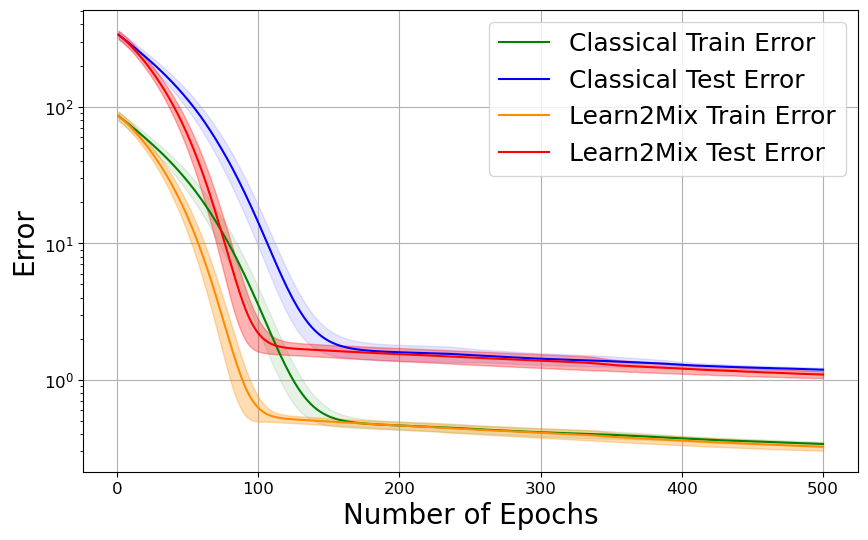

In [24]:
# Step 2: Compute means and 95% confidence intervals
def compute_mean_and_CI(data):
    mean = np.mean(data, axis=0)
    std_error = np.std(data, axis=0) / np.sqrt(data.shape[0])  # Standard error of the mean
    stdev = np.std(data, axis=0)
    ci = 1.96 * std_error  # 95% CI for a normal distribution
    return mean, ci, stdev

A = classical_errors.T[:,:]; B = train_errors.T[:,:]
mean_A, ci_A, stdev_A = compute_mean_and_CI(A)
mean_B, ci_B, stdev_B = compute_mean_and_CI(B)

X = classical_test_errors.T[:,:]; Z = test_errors.T[:,:]
mean_X, ci_X, stdev_X = compute_mean_and_CI(X)
mean_Z, ci_Z, stdev_Z = compute_mean_and_CI(Z)

print(f'Mean DNN:       {mean_X[len(mean_X)-1].round(4)}, STDEV DNN:      {stdev_X[len(stdev_X)-1].round(4)}')
print(f'Mean L2M:       {mean_Z[len(mean_Z)-1].round(4)}, STDEV L2M:      {stdev_Z[len(stdev_Z)-1].round(4)}')

# Step 3: Plot the results
epochs_all = list(range(1, X.shape[1] + 1))
plt.figure(figsize=(10, 6))

# Plotting for A
plt.fill_between(epochs_all, mean_A - ci_A, mean_A + ci_A, color='green', alpha=0.1, zorder=0)
plt.plot(epochs_all, mean_A, 'g-', label="Classical Train Error", zorder=20)

# Plotting for X
plt.fill_between(epochs_all, mean_X - ci_X, mean_X + ci_X, color='blue', alpha=0.1, zorder=0)
plt.plot(epochs_all, mean_X, 'b-', label="Classical Test Error", zorder=20)

# Plotting for B
plt.fill_between(epochs_all, mean_B - ci_B, mean_B + ci_B, color='darkorange', alpha=0.3, zorder=10)
plt.plot(epochs_all, mean_B, '-', color='darkorange', label="Learn2Mix Train Error", zorder=30)

# Plotting for Z
plt.fill_between(epochs_all, mean_Z - ci_Z, mean_Z + ci_Z, color='red', alpha=0.3, zorder=10)
plt.plot(epochs_all, mean_Z, 'r-', label="Learn2Mix Test Error", zorder=30)

# Additional plot settings
plt.xlabel("Number of Epochs", fontsize=20)
plt.ylabel("Error", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.legend(prop={'size': 18},loc='upper right')
plt.grid(True)
plt.savefig('test.png', bbox_inches='tight')